In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
import statsmodels.api as sm


In [133]:
from google.colab import drive
import pandas as pd
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Path ke file Spreadsheet di Google Drive
file_path = '/content/drive/My Drive/Superstore.csv'

# Load file Spreadsheet ke DataFrame
data = pd.read_csv(file_path, encoding='latin-1')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [178]:
data.shape

(9994, 21)

In [134]:
data.dtypes

Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object

In [135]:
import pandas as pd
# Ubah kolom Order Date dan Ship Date menjadi datetime64[ns]
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])

# Verifikasi tipe data
print(data['Order Date'].dtype)
print(data['Ship Date'].dtype)


datetime64[ns]
datetime64[ns]


In [150]:
set(data['Category'])

{'Furniture', 'Office Supplies', 'Technology'}

#Data Preprocessing

In [153]:
 furniture = data.loc[data['Category'] == 'Furniture']

# memiliki data deret waktu selama 4 tahun untuk penjualan furnitur.
print(furniture['Order Date'].min())
furniture['Order Date'].max()

2014-01-06 00:00:00


Timestamp('2017-12-30 00:00:00')

In [154]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

In [155]:
# furniture data
furniture.sort_values('Order Date')
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [156]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

#Indexing time-series data

In [157]:
furniture = furniture.set_index('Order Date')
#furniture = furniture.apply(lambda x: x.set_index('Order Date'))
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [158]:
# Averaging Daily Sales
y = furniture['Sales'].resample('MS').mean()

In [159]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Furniture data time-series visualization

<Axes: xlabel='Order Date'>

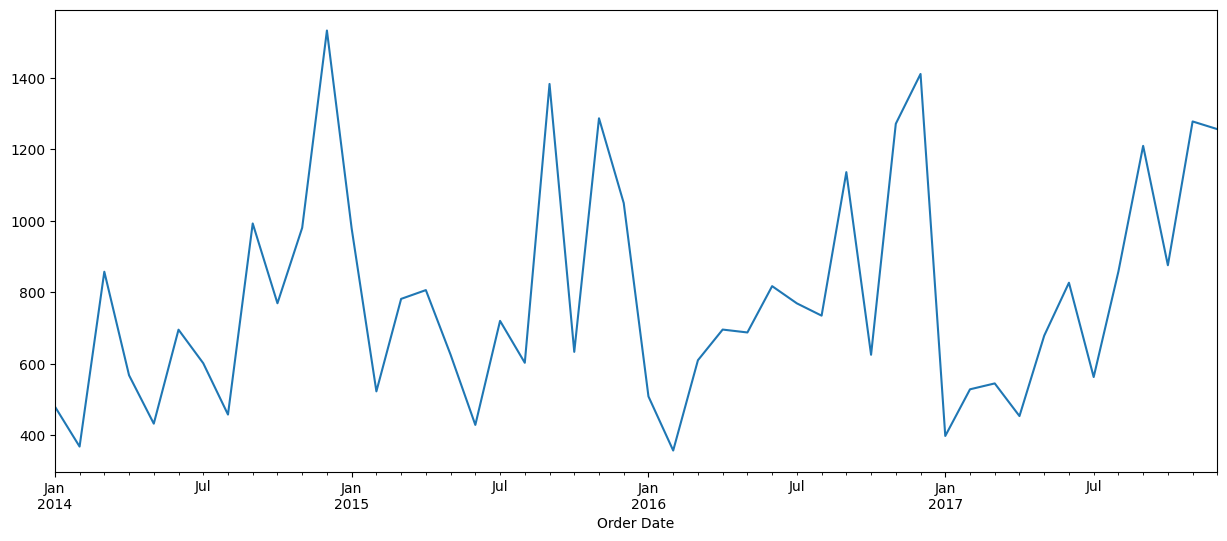

In [160]:
y.plot(figsize=(15, 6))

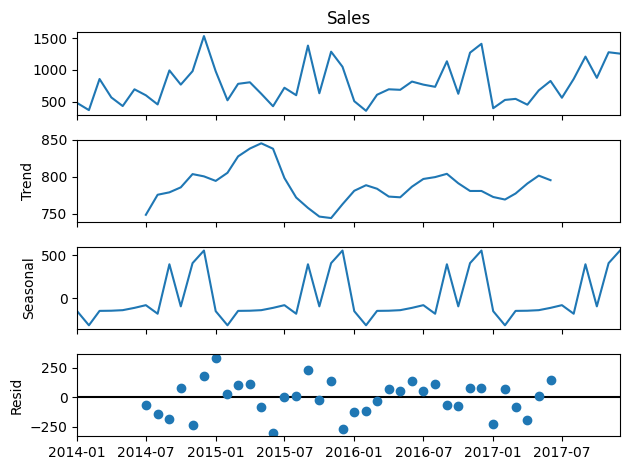

In [161]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

Plot di atas menunjukkan bahwa penjualan furnitur sangat tidak stabil dengan musim dan tren yang mudah diamati.

## Time Series forecasting with ARIMA Model

Model ARIMA ditunjukkan dengan notasi: ARIMA (p, d, q) di mana:
* p menunjukkan musiman
* d menunjukkan tren
* q menunjukkan noise dalam data

Mengkonfigurasi model SARIMA melibatkan pemilihan parameter untuk komponen tren dan musiman dari deret waktu.

Komponen Tren:

* p adalah urutan autoregresi untuk tren.
* d adalah urutan perbedaan untuk tren.
* q adalah urutan moving average untuk tren.

Komponen Musiman:

* p adalah urutan autoregresi untuk komponen musiman.
* d adalah urutan perbedaan untuk komponen musiman.
* q adalah urutan moving average untuk komponen musiman.
* m adalah jumlah langkah waktu dalam satu periode musiman.

In [162]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)



Setelah kita memiliki semua parameter yang mungkin untuk model SARIMA kita, kita akan mencari parameter terbaik untuk melatih model tersebut pada akhirnya. SARIMA adalah singkatan dari model **Seasonal AutoRegressive Integrated Moving Average**, yang merupakan perluasan dari model ARIMA yang digunakan untuk memodelkan komponen musiman juga. Jadi, kita tidak perlu membuat deret waktu yang stasioner (non-musiman) terlebih dahulu sebelum melakukan peramalan.

In [163]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205915


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1486.4539747597614
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309212006
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:302.2702899793675
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418338


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1295.2899372410943
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:304.24882803028567
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.92522707581


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2667.387883363441
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.5607429809145
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:291.6261389673307


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.58424534967315


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2444.645710923306
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946868


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:291.8725576486841
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.8947668414504


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1531.606788834928
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.6378567289681
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:304.96712281679567
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.7889663004408


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1224.576614678407
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109212
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:306.91132001514256
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176817297


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2167.7044882473756
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.87055484828534
ARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC:279.5806233397717
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.18329774427696


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2380.8909305028806
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.7574368417304


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:281.5576621461244
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067713


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1353.502609552322
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.4632147852136
ARIMA(1, 0, 0)x(0, 1, 1, 12) - AIC:304.20776751609674
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679351927


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1375.8256035989962
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.4664675084583
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:304.5842692143874
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442186972


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:2211.9175226720477
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.36851958159593


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:293.34221939658994
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.5763323876305


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:2514.837614878139
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560021219024


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:293.75131881018297
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1301.7711535854626
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.2003422281136
ARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:300.2130611619093
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587844645
ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1451.2287193398636
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.6270901345404


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:302.3264992509151
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835765
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:244.37563083563265
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687610683


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:281.38730069394
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660841


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1338.0290868778068
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.78754395346493


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:283.36610170869045


Diperoleh nilai AIC terendah: IC value: 297.788 for ARIMA(1, 1, 1)x(1, 1, 0, 12). Akan digunakan parameter terbaik ini dalam model ini.

Di sini, **Akaike information criterion (AIC)** adalah sebuah ukuran yang digunakan untuk membandingkan kualitas relatif dari model statistik untuk satu set data tertentu. Dalam konteks ini, AIC membantu memilih model yang paling cocok untuk data tersebut dengan memperhitungkan trade-off antara kesesuaian model dan kompleksitasnya.

AIC mengestimasi jumlah informasi relatif yang hilang dari sebuah model: semakin sedikit informasi yang hilang (nilai AIC yang lebih rendah), semakin baik model tersebut dalam menjelaskan data.

In [164]:
# Training the ARIMA model.
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


## Validating the model forecasts

Untuk memvalidasi hasil model, akan dibandingkan penjualan aktual (actual sales) dengan penjualan yang diprediksi (predicted sales( dari data deret waktu (time series) mulai dari 2017/01/01 hingga akhir data.

            lower Sales  upper Sales
Order Date                          
2017-01-01   204.675958   895.517835
2017-02-01    31.859839   721.913128
2017-03-01   296.215963   985.551784
2017-04-01   373.138220  1061.818485
2017-05-01   347.351717  1035.430656
2017-06-01   471.969347  1159.494727
2017-07-01   433.445498  1120.459611
2017-08-01   385.912543  1072.453013
2017-09-01   806.828497  1492.928942
2017-10-01   291.097940   976.788520
2017-11-01   948.687443  1633.995322
2017-12-01  1074.694592  1759.644318


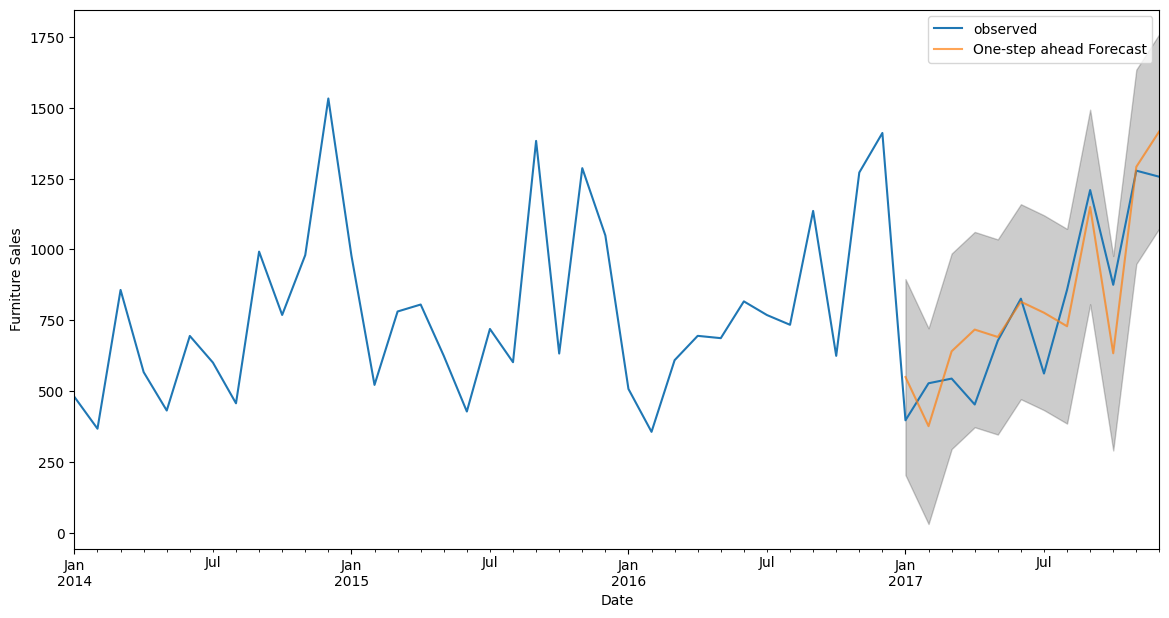

In [166]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Plot di atas menunjukkan bahwa nilai prediksi selaras dengan nilai sebenarnya yang menunjukkan musiman naik. Sekarang, kita menghitung Mean Square Error dari nilai prediksi kita terhadap nilai asli.


In [167]:
y_predicted = pred.predicted_mean
y_true = y['2017-01-01':]
mse = ((y_predicted - y_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))

Mean Square Error is: 22993.5677


In [168]:
print('Root Mean Square Error is:', np.sqrt(mse))

Root Mean Square Error is: 151.6363006828938


# Future Forecasts

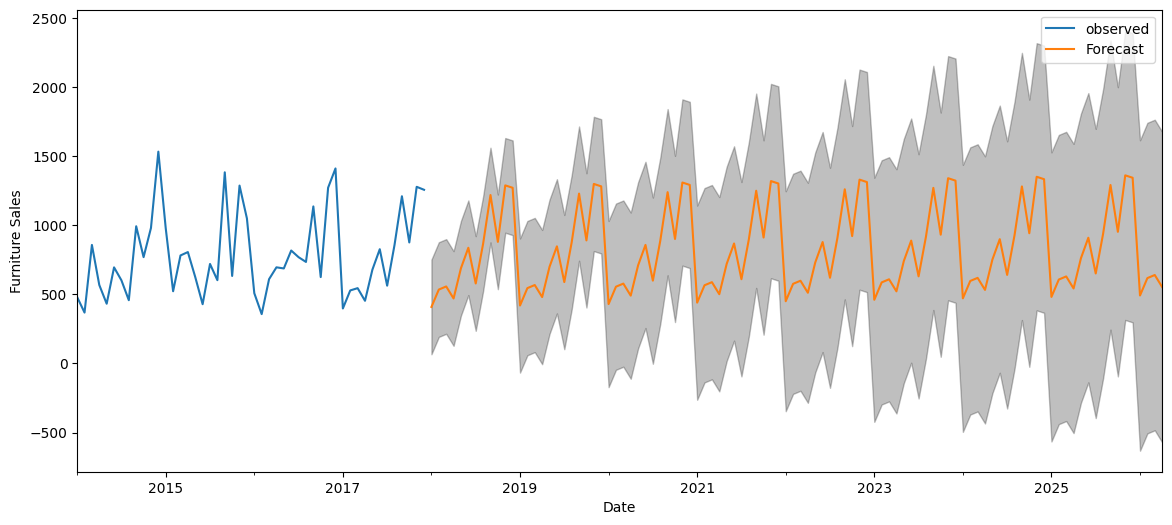

In [171]:
# Forecasting the future (out of sample) values.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Di sini, perhatikan bahwa interval kepercayaan meningkat saat kita bergerak lebih jauh ke masa depan. Model menjadi kurang percaya diri dalam memprediksi nilai saat kita bergerak lebih jauh ke depan.

Data kami memiliki 3 kategori: Furniture', 'Office Supplies' dan, 'Technology'. Mari bandingkan time series terhadap'Furniture' dan 'Office Supplies'

# Furniture vs Office Supplies

In [173]:
furniture = data.loc[data['Category'] == 'Furniture']
office = data.loc[data['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [174]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

akan dilakukan penggabungan time series untuk perbandingan

In [175]:
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()

,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


## Visualizing Furniture vs Office Sales time series

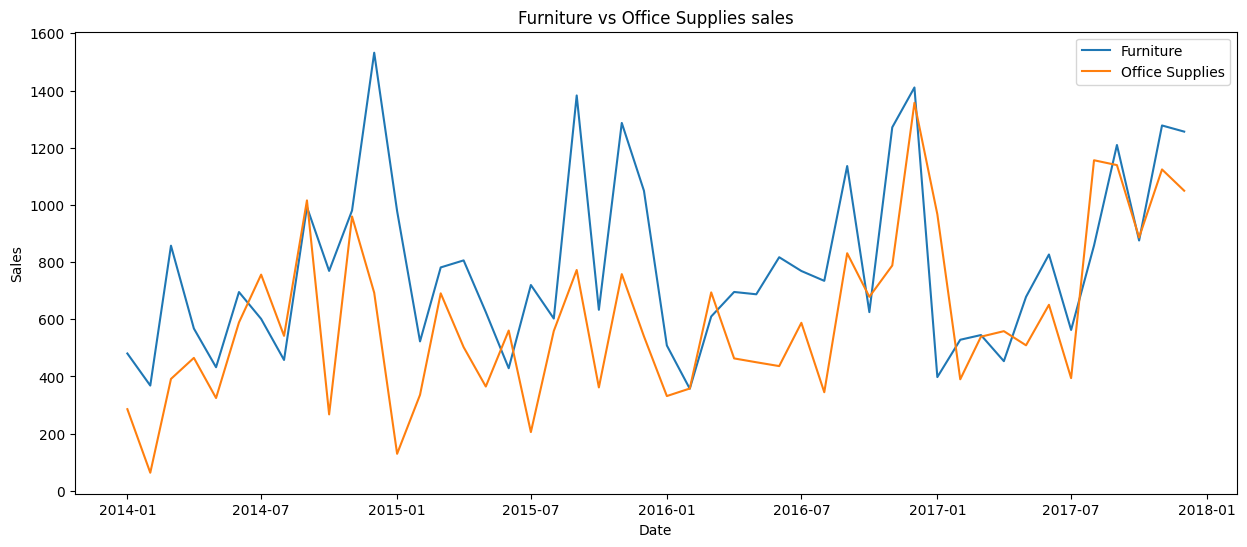

In [176]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()

### Hasil Pengamatan:

* Plot di atas dengan jelas menunjukkan bahwa baik furniture maupun office supplies menunjukkan komponen musiman yang serupa.
* Penjualan umumnya rendah pada awal setiap tahun seperti yang terlihat dari penurunan kemiringan garis pada awal tahun 2014, 2015, 2016, dll.
* Selain itu, penjualan rata-rata bulanan furniture lebih tinggi daripada penjualan perlengkapan kantor/office supplies. Hal ini mungkin karena biaya furnitur jauh lebih mahal dibandingkan dengan utilitas kantor.

Tetapi ada beberapa contoh dalam rangkaian waktu di mana penjualan perlengkapan kantor melampaui furnitur. Hal ini terutama terjadi pada bulan **Juli 2014** untuk pertama kalinya dalam data.